## Importing libraries

In [11]:
import tensorflow as tf
import numpy as np
import pandas as pd
import json
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

## Loading the data

In [2]:
url_data = 'https://raw.githubusercontent.com/TeodorRusKvi/Tekstanalyse/main/git_NLP_data/'

# Last inn 'X_train_LSTM' fra en CSV-fil
X_df = pd.read_csv(url_data+'X_tensorflow.csv')
# Konverter hele DataFrame til et NumPy array
X = X_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
y_df = pd.read_csv(url_data+'y_liberal.csv')
# Konverter hele DataFrame til et NumPy array
y = y_df.to_numpy()

# Last inn 'y_train_LSTM' fra en CSV-fil
embeddings_GloVe = pd.read_csv(url_data+'embeddings_glove.csv')
# Konverter hele DataFrame til et NumPy array
embeddings_GloVe = embeddings_GloVe.to_numpy()


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [3]:
# Loading the params from CNN-LSTM from the saved JSON-fil
with open('best_trial_1.json', 'r') as f:
    data = json.load(f)
    params = data['params']

## A simpel LSTM model with tuned hyperparameters

In [13]:
tf.random.set_seed(42)


def model_build(params):
    lstm_units = params['lstm_units']
    dense_2_units = params['dense_2_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    model = Sequential()
    model.add(Input(shape=(20,)))
    # Adding the Embedding layer with pre-trained weights and specifying input_length
    model.add(Embedding(input_dim=embeddings_GloVe.shape[0],
                        output_dim=embeddings_GloVe.shape[1],
                        weights=[embeddings_GloVe],
                        trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units, # Number of hidden states, number of reccurent units for each vector
        activation='tanh',
        recurrent_activation='sigmoid',
        recurrent_dropout=0.2,
        return_sequences=False)))

    model.add(Dense(dense_2_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
    return model

num_classes = 1
model = model_build(params)
# Model summary
model.summary()

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           2223500   
                                                                 
 dropout_2 (Dropout)         (None, 20, 100)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 160)               115840    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 92)                14812     
                                                                 
 dropout_3 (Dropout)         (None, 92)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 93        
                                                      

In [14]:
input_length = 20
num_classes = 1
EPOCHS=20
BATCH_SIZE = 32

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)


history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    batch_size=BATCH_SIZE,
                    callbacks=early_stopping_callback)

Epoch 1/20
282/282 [==============================] - 21s 29ms/step - loss: 0.5990 - accuracy: 0.6807 - val_loss: 0.5510 - val_accuracy: 0.7256
Epoch 2/20
282/282 [==============================] - 7s 26ms/step - loss: 0.5399 - accuracy: 0.7225 - val_loss: 0.5300 - val_accuracy: 0.7350
Epoch 3/20
282/282 [==============================] - 7s 25ms/step - loss: 0.4946 - accuracy: 0.7588 - val_loss: 0.5299 - val_accuracy: 0.7495
Epoch 4/20
282/282 [==============================] - 7s 24ms/step - loss: 0.4404 - accuracy: 0.7954 - val_loss: 0.5386 - val_accuracy: 0.7479
Epoch 5/20
282/282 [==============================] - 7s 24ms/step - loss: 0.3881 - accuracy: 0.8176 - val_loss: 0.5583 - val_accuracy: 0.7350


## Evaluation of the model

61/61 [==============================] - 0s 7ms/step - loss: 0.5504 - accuracy: 0.7496
Test Loss: 0.5504266619682312
Test Accuracy: 0.7496111989021301


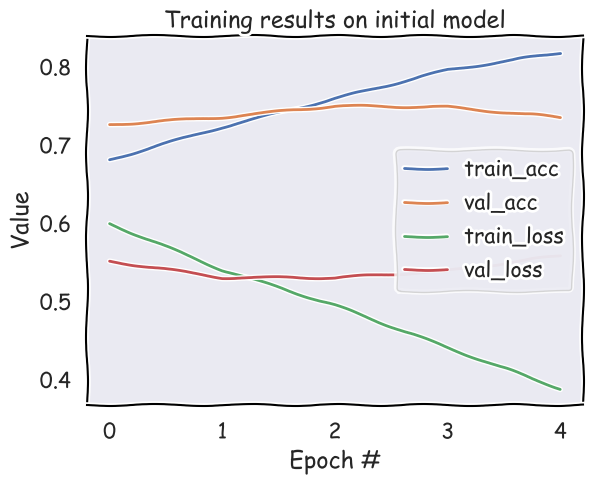

In [15]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

with plt.xkcd():
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')



    plt.xlabel('Epoch #')
    plt.ylabel('Value')
    plt.title('Training results on initial model')
    plt.legend()

    plt.show()

## Classification metrics

31/31 [==============================] - 1s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.64      0.64       665
           1       0.81      0.81      0.81      1264

    accuracy                           0.75      1929
   macro avg       0.72      0.72      0.72      1929
weighted avg       0.75      0.75      0.75      1929

Accuracy: 0.749611197511664
Recall: 0.8085443037974683
Precision: 0.8091844813935075
F1 Score: 0.8088642659279779


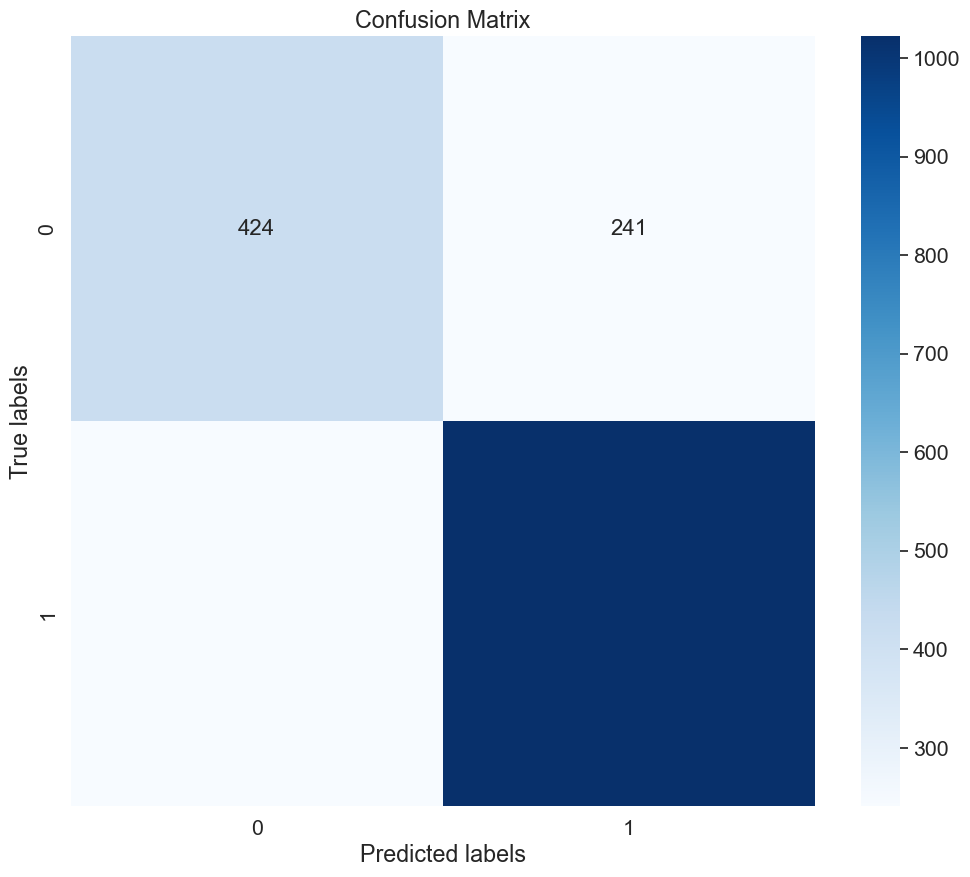

In [16]:
# Predict probabilities for the positive class (class 1)
probabilities = model.predict(X_test, batch_size=64)

# Ensure that probabilities are in the expected format
y_pred = (probabilities > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculating different metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print each metric
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1 Score:", f1)

# Creating a confusion matrix for visualization
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(12,10))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')  # fmt='g' to avoid scientific notation

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()